# Analyze Metal uptake

In [1]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [2]:
from coralme.builder.main import MEBuilder, MEReconstruction, METroubleshooter
from coralme.builder.curation import MECurator, MEManualCuration
from coralme.builder.helper_functions import flux_based_reactions,exchange_single_model
import coralme
import pickle
import pandas
import os
import tqdm
import numpy
import json
pandas.set_option('display.max_colwidth', None)
from coralme.builder.helper_functions import *
import matplotlib.pyplot as plt

## Analyze

In [3]:
with open('names.json') as f:
    names = json.load(f)

### Load models

In [4]:
def load_me(filename='me_model.pickle'):
    with open(filename, "rb") as f:
        return pickle.load(f)
    
def get_org_dirs(directory,files=False):
    if files:
        return [i for i in os.listdir(directory) if '.pkl' in i]
    return [i for i in os.listdir(directory) if os.path.isdir(directory+i) and '.' not in i and '_' not in i]

def run(i,directory,files=False,step=2,solve=False):
    if files:
        modelpath = directory + i
    elif step == 2:
        modelpath = directory + '{}/MEModel-step2-{}.pkl'.format(i,i)
    elif step == 3:
        modelpath = directory + '{}/MEModel-step3-{}-TS.pkl'.format(i,i)
    model = load_me(modelpath)
    if solve:
        model.optimize()
    return i.split(".pkl")[0], model

def load_models_from_directory(directory,solve=False, step = 2, files=False):
    d = {}
    dirs = get_org_dirs(directory,files=files)
    for org in tqdm.tqdm(dirs):
        args = [org,directory]
        kwds = {'files' : files, 'step' : step, 'solve' : solve}
        i,model = run(*args,**kwds)
        d[i] = model
    return d

In [5]:
models = {
#     'curated':load_models_from_directory('./published/',step=2),
    'clean':load_models_from_directory('./clean/',step=3)
         }

 10%|▉         | 2/21 [00:01<00:12,  1.52it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-16
Read LP format model from file /tmp/tmprakyi5ei.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp6pn31jh_.lp
Reading time = 0.01 seconds
: 1802 rows, 5090 columns, 19612 nonzeros
Read LP format model from file /tmp/tmpuv208r_y.lp
Reading time = 0.01 seconds
: 1817 rows, 5084 columns, 19460 nonzeros


 38%|███▊      | 8/21 [00:17<00:28,  2.19s/it]

Read LP format model from file /tmp/tmpt9yab0z_.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmplc1y7dyw.lp
Reading time = 0.00 seconds
: 649 rows, 1508 columns, 6436 nonzeros
Read LP format model from file /tmp/tmpsduxyysr.lp
Reading time = 0.00 seconds
: 651 rows, 1504 columns, 6386 nonzeros


 71%|███████▏  | 15/21 [00:30<00:11,  1.84s/it]

Read LP format model from file /tmp/tmpetwerbaw.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpf50bx76a.lp
Reading time = 0.00 seconds
: 768 rows, 1698 columns, 7642 nonzeros
Read LP format model from file /tmp/tmpyhkbhplu.lp
Reading time = 0.00 seconds
: 787 rows, 1692 columns, 7596 nonzeros


100%|██████████| 21/21 [00:39<00:00,  1.88s/it]


### Load

In [6]:
results_dict = {}
directory = "./analysis/10steps/"
for file in os.listdir(directory):
    if ".csv" not in file: continue
    results_dict[file.split("_C_")[0]] = pandas.read_csv(directory + file,index_col=0)

results_dict = {names[k]:v for k,v in results_dict.items()}

### Plot

In [7]:
def get_exchanges(org,metals):
    model = models["clean"][org]
    exchanges = ["^EX_{}.?e.?$".format(m) for m in metals]
    gaps = ["^TS_{}.?[a-z].?$".format(m) for m in metals]
    sinks = ["^SK_{}.?[a-z].?$".format(m) for m in metals]
    regex = "|".join(exchanges+sinks+gaps)
    return [r.id for r in model.reactions.query(regex)]


In [8]:
def get_sensitivity(org,metal):
    sensitivity = {}
    if isinstance(metal,str):
        metal = [metal]
    r = get_exchanges(org,metal)
    if not r:
        return None
    sensitivity[org] = results_dict[names[org]].loc[r].sum().to_dict()
    return pandas.DataFrame.from_dict(sensitivity).dropna().abs()

In [9]:
def get_normalized_flux(org,metal):
    sensitivity_df = get_sensitivity(org,metal)
    df = (sensitivity_df)
    df['mu'] = results_dict[names[org]].loc['biomass_dilution']
    df = df.div(df.max())
    df = df.loc[[str(i) for i in range(14)]]
    return df

In [10]:
def plot(org,metal, ax=None):
    # Normalize
    df = get_normalized_flux(org,metal)
    df[org].plot(ax=ax,style='-o')
    df['mu'].plot(ax=ax,style='--')
    
    ax.set_xticks(range(df.shape[0]))
    ax.set_xticklabels(["{:.1f}".format(i) for i in numpy.arange(0.1,1.5,0.1)])
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

In [11]:
import pandas
import os

In [12]:
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'

## Examples

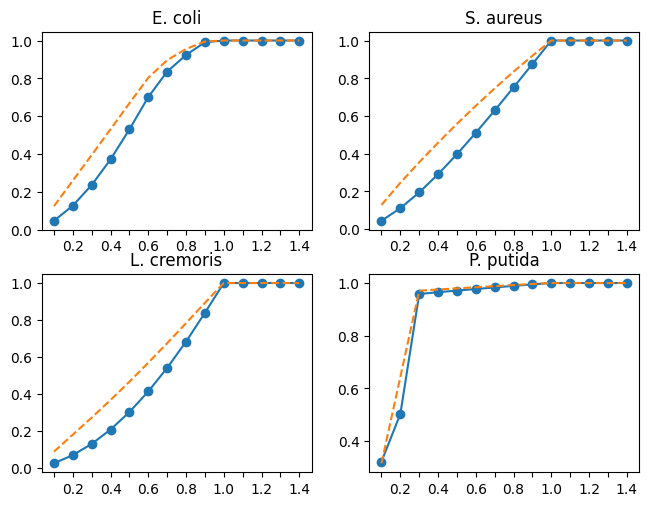

In [13]:
ex = ['ecoli','staph','lcremoris','pputida']
fig,ax = plt.subplots(2,2,figsize = (5*1.34,5))
ax = ax.flatten()
plt.tight_layout()
for idx,org in enumerate(ex):
    plot(org,"mg2",ax=ax[idx])
    ax[idx].set_title(names[org])
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("./figures/metal_examples.svg",format="SVG")

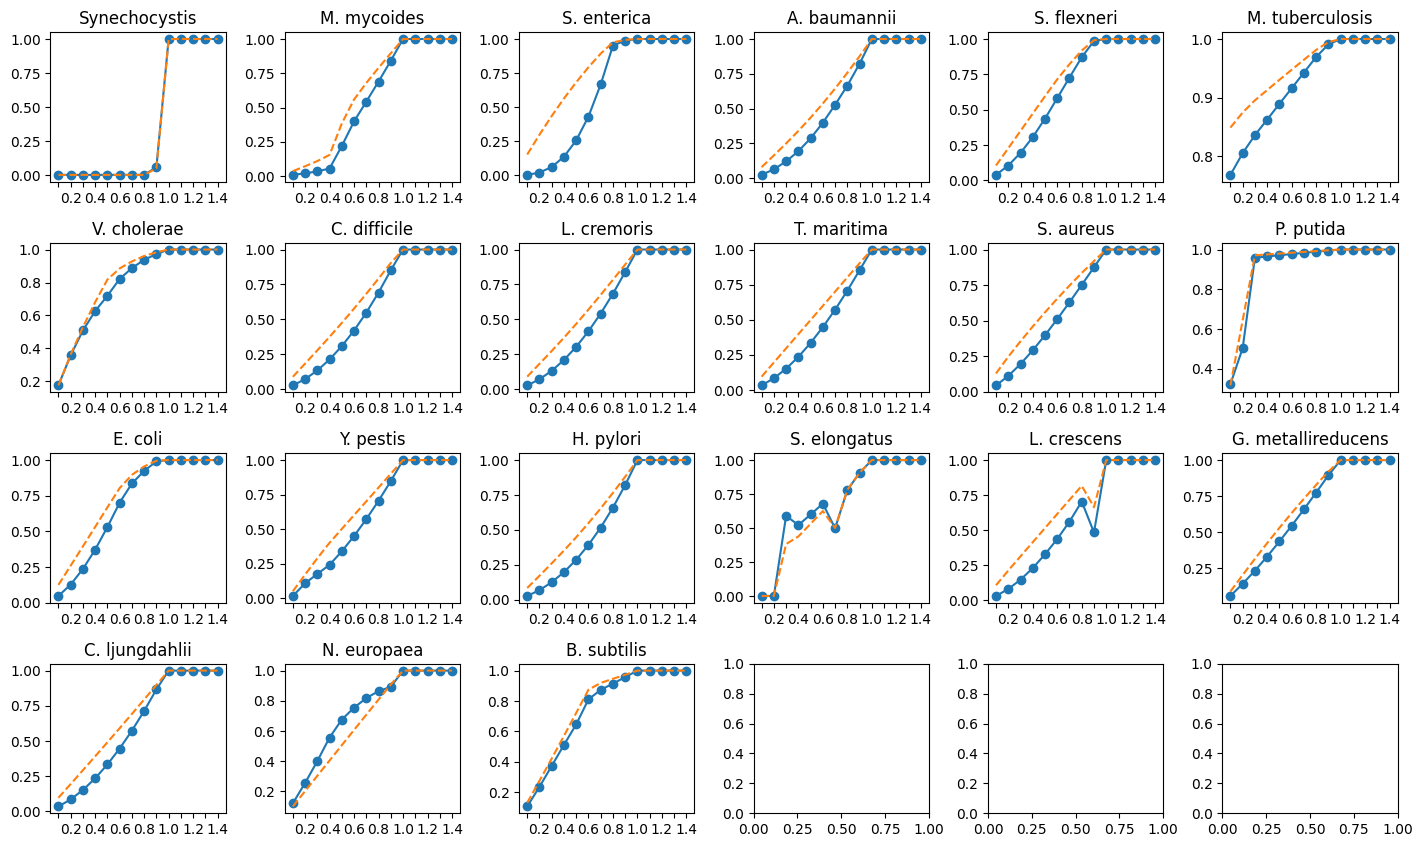

In [14]:
ex = list(models['clean'].keys())
fig,ax = plt.subplots(4,6,figsize = (20/1.4,12/1.4))
ax = ax.flatten()
plt.tight_layout
for idx,org in enumerate(ex):
    plot(org,"mg2",ax=ax[idx])
    ax[idx].set_title(names[org])
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("./figures/mg2_all.svg",format="SVG")